**BIVARIATE**

* Categorical vs Categorical Target --> Count + pct for each category and target category; Count + pct for each target category; Grouped count plot with hue=target; Grouped bar plot with percentages with hue=target and lines indicating target percentages without grouping

* Categorical vs Numerical Target --> Descibe for numerical target alone and for each category; Boxplot for each category with reference line with mean(median) for target alone; overlapping distributions for each value of categorical variable; QQ-plot 

* Numerical vs Categorical Target --> Describe for numerical variable alone and for each target category; Boxplot for each category with reference line with mean (median) for variable alone; overlapping distributions for each value of target variable; QQ-plot

* Numerical vs Numerical target --> Describe for both variable and target; Correlation values; Scatterplot


**TRIVARIATE**

* 2 Categorical vs Categorical target --> Count + pct for each category and target category; Count + pct for each target category; For each value of target, two heatmaps: one with percentages of the corresponding value for each pair of category values, and one with the difference between the first one, and the pct of the target value without grouping.

* 2 categorical vs numerical target --> Grouped boxplot with x=categorical, y=target, hue=categorical

* 1 Categorical, 1 Numerical vs Categorical target --> Grouped boxplot with x=Categorical, y=numerical, hue=target

* 1 Categorical, 1 Numerical vs Numerical target --> Scatterplot with hue=categorical

* 2 Numerical vs Categorical target --> Scatterplot with hue=target

* 2 Numerical vs numerical target --> heatmap


In [1]:
'''
Helper functions to do EDA
'''

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import os
from matplotlib.gridspec import GridSpec
from dython import nominal

In [2]:
sns.__version__

'0.11.0'

## Read Data

In [3]:
DATA_PATH = os.path.join(os.getcwd(), 'titanic')

In [4]:
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'))
test_df = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'))

In [5]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [7]:
train_df["Pclass"] = train_df["Pclass"].astype("category") 

## Bivariate plots

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
#del sys.modules['AutoEDA']
#del test

In [10]:
import sys, importlib
#importlib.reload(sys.modules['AutoEDA'])
import AutoEDA.AutoEDA as eda
#import AutoEDA as eda

In [11]:
%matplotlib notebook

In [12]:
column_cat, column_num = "Pclass", "Age"
column_cat2 = "Sex"
column_cat3 = "Survived"
column_num1, column_num2 = "Age", "Fare"
column_num3 = "SibSp"
dataframe = train_df

In [13]:
dataframe["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [14]:
from matplotlib.widgets import Slider


In [15]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [16]:
sns.set_style('darkgrid')

In [17]:
corr_dict = nominal.compute_associations(dataframe, theil_u=True, clustering=True,
                    nan_strategy='drop_samples',
                    mark_columns=True)

In [18]:
corr_dict

,Name (nom),Ticket (nom),Cabin (nom),Pclass (nom),Embarked (nom),Sex (nom),SibSp (con),Parch (con),Fare (con),PassengerId (con),Survived (con),Age (con)
Name (nom),1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Ticket (nom),0.910171,1.000000,0.968382,1.000000,0.989270,0.690770,0.924306,0.940326,1.000000,0.894709,0.881379,0.864027
Cabin (nom),0.920735,0.979622,1.000000,1.000000,0.974490,0.729169,0.961750,0.968549,0.937363,0.907671,0.874317,0.921372
Pclass (nom),0.094195,0.103491,0.102304,1.000000,0.056916,0.003826,0.105744,0.075933,0.330677,0.138919,0.115908,0.312825
Embarked (nom),0.135522,0.147300,0.143434,0.081887,1.000000,0.002896,0.174974,0.103813,0.242843,0.066022,0.109203,0.088832
Sex (nom),0.132914,0.100875,0.105261,0.005399,0.002840,1.000000,0.104291,0.089581,0.130433,0.025205,0.532418,0.184969
SibSp (con),1.000000,0.924306,0.961750,0.105744,0.174974,0.104291,1.000000,0.255346,0.286433,-0.083488,0.106346,-0.156162
Parch (con),1.000000,0.940326,0.968549,0.075933,0.103813,0.089581,0.255346,1.000000,0.389740,-0.051454,0.023582,-0.271271
Fare (con),1.000000,1.000000,0.937363,0.330677,0.242843,0.130433,0.286433,0.389740,1.000000,0.029740,0.134241,-0.092424
PassengerId (con),1.000000,0.894709,0.907671,0.138919,0.066022,0.025205,-0.083488,-0.051454,0.029740,1.000000,0.148495,0.030933


df_corr, df_corr_ordered, (fig, ax) = eda.associations(dataframe)

<IPython.core.display.Javascript object>


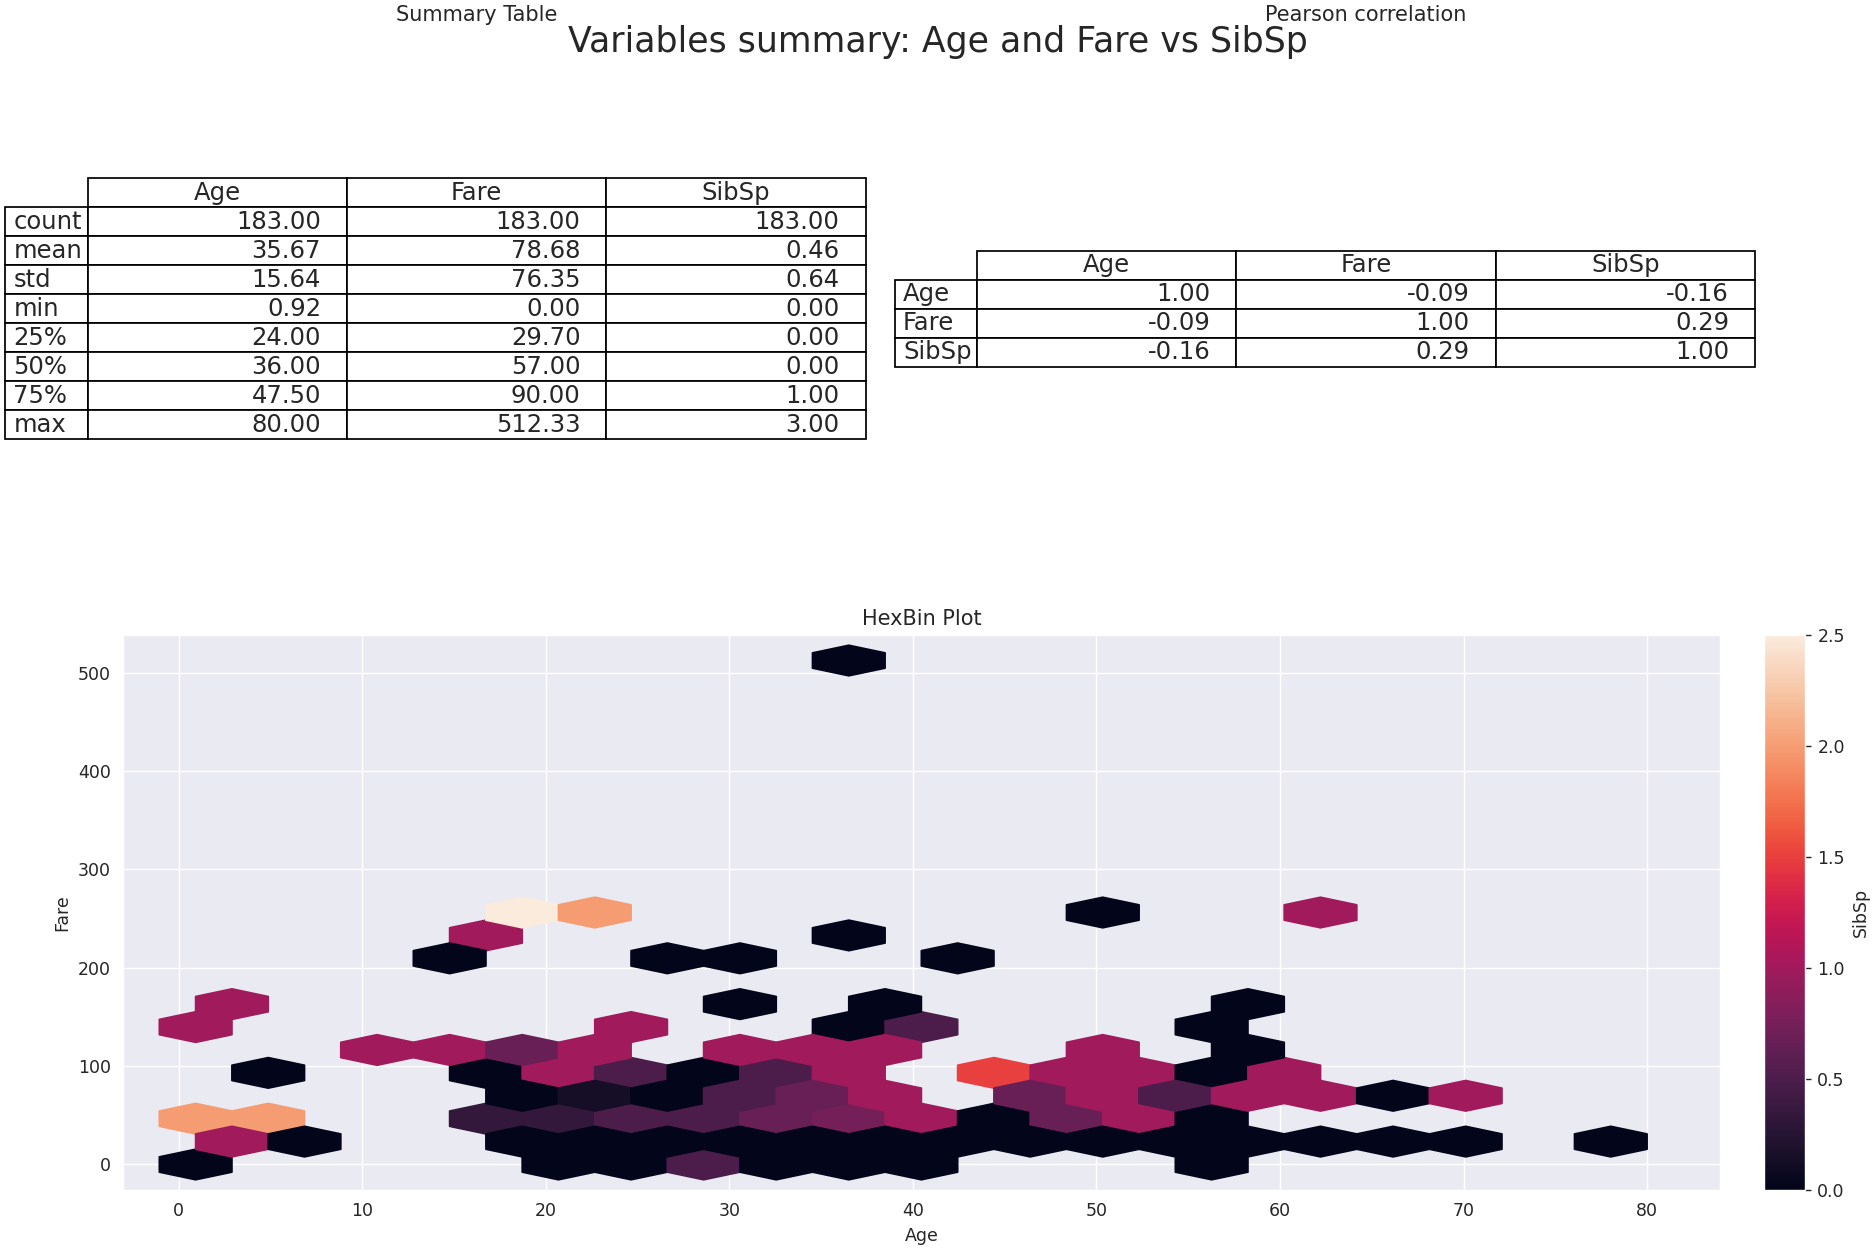

In [19]:
eda.two_numerical_vs_numerical(dataframe, column_num1, column_num2, column_num3,
                         palette=None, ax=None, order=None)

<IPython.core.display.Javascript object>


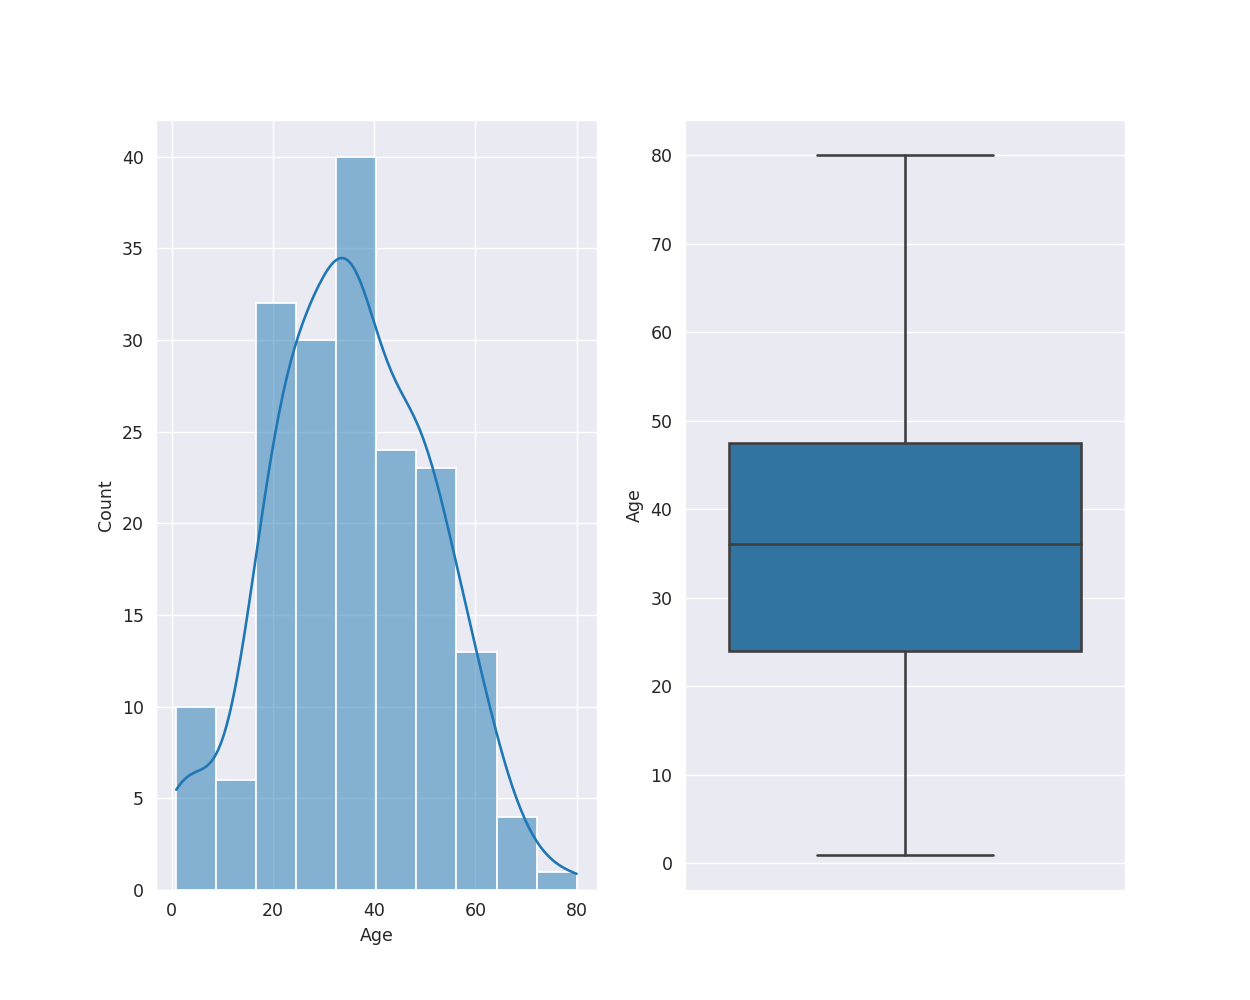

((<Figure size 1000x800 with 2 Axes>,
  array([<AxesSubplot:xlabel='Age', ylabel='Count'>,
         <AxesSubplot:ylabel='Age'>], dtype=object)),
 count    183.000000
 mean      35.674426
 std       15.643866
 min        0.920000
 25%       24.000000
 50%       36.000000
 75%       47.500000
 max       80.000000
 Name: Age, dtype: float64)

In [36]:
eda.numerical_univariate(dataframe, 'Age', palette=None, ax=None)

### Summary tables

* Categorical: count_values and pct
* Numerical: Describe

* Categorical vs Numerical: Describe for whole numerical and describe for each category
* Categorical vs Categorical: count values and pct for both vars alone, crosstab and crosstab with pct
* Numerical vs Numerical: Describe for both variables

* 2 categorical vs categorical: crosstab with index the first 2 categorical, and column the third categ
* 

In [20]:
dataframe.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [42]:
eda.compute_summary_categorical_vs_categorical(dataframe, 'Pclass', 'Sex')

(Sex     female  male  All
 Pclass                   
 1           74    84  158
 2            9     6   15
 3            5     5   10
 All         88    95  183,
 Sex       female      male
 Pclass                    
 1       0.468354  0.531646
 2       0.600000  0.400000
 3       0.500000  0.500000
 All     0.480874  0.519126)

In [26]:
column = 'Pclass'
d = {}
c = dataframe[column].value_counts(dropna=False)
p = dataframe[column].value_counts(dropna=False, normalize=True)
d[column] = c
d[column + "_pct"] = p
#df_cnts = pd.concat([c,p], axis=1, keys=['counts', '%'])
#dataframe[column].describe()
#pd.DataFrame(d)

count     183
unique      3
top         1
freq      158
Name: Pclass, dtype: int64

In [38]:
test = dataframe[["Age", "Survived"]]
t1 = test["Age"].describe()
t2 = test.groupby("Survived")["Age"].describe().transpose()

In [42]:
t1.to_frame("Age")

,Age
count,183.000000
mean,35.674426
std,15.643866
min,0.920000
25%,24.000000
50%,36.000000
75%,47.500000
max,80.000000


In [46]:
pd.concat([t1, t2], axis=1)

,Age,0,1
count,183.000000,60.000000,123.000000
mean,35.674426,41.350000,32.905854
std,15.643866,15.739484,14.890113
min,0.920000,2.000000,0.920000
25%,24.000000,29.750000,23.000000
50%,36.000000,44.500000,33.000000
75%,47.500000,52.500000,42.000000
max,80.000000,71.000000,80.000000


In [32]:
pd.crosstab(dataframe["Survived"], [dataframe["Sex"], dataframe["Embarked"], dataframe["Pclass"]],
           margins=True)

Sex      female                 male                  All
Embarked      C     Q   S          C     Q   S           
Pclass        1  2  1   1  2  3    1  2  1   1  2  3     
Survived                                                 
0             1  0  0   2  1  2   15  1  1  33  1  3   60
1            32  1  1  38  7  3   15  0  0  20  4  2  123
All          33  1  1  40  8  5   30  1  1  53  5  5  183